In [1]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker




/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [4]:

count = torch.cuda.device_count()
print(count)

2

In [5]:

torch.cuda.set_device(1)

In [6]:
print(f"Current GPU: {torch.cuda.current_device()}")

Current GPU: 1

In [8]:
adata = sc.read_h5ad('/home/data/sdzl14/NSCLC/zong/epi.h5ad')
adata = adata.copy()

In [9]:
adata.obs['celltype_fine'] = adata.obs['celltype_fine'].cat.add_categories('NaN').fillna('NaN')

In [10]:
print(adata.obs['celltype_fine'].value_counts())

celltype_fine
NaN                156429
Tumor               78144
AT2                 28767
Ciliated cell        6220
Club cell            6131
AT1                  4249
Serous cell          1114
Basal cell           1023
Epithelial cell       302
Name: count, dtype: int64

In [11]:
print(adata.obs['Dataset'].value_counts())

Dataset
Tagore_S_2025                       156429
Peng_Zhang_2024                      62947
Kim_Lee_2020                         15008
He_Fan_2021                           5088
Lambrechts_Thienpont_2018_6149v2      4916
Travaglini_Krasnow_2020               3258
Maynard_Bivona_2020                   2374
Vieira_Teichmann_2019                 1839
Lambrechts_Thienpont_2018_6653        1675
Laughney_Massague_2020                1130
Goveia_Carmeliet_2020                  475
Lambrechts_Thienpont_2018_6149v1       404
UKIM-V                                 307
Name: count, dtype: int64

In [15]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    n_top_genes=2000,
    subset=True,
    inplace=True,batch_key="Dataset")

In [19]:
adata.obs['Dataset'].cat.categories

Index(['Goveia_Carmeliet_2020', 'He_Fan_2021', 'Kim_Lee_2020',
       'Lambrechts_Thienpont_2018_6149v1', 'Lambrechts_Thienpont_2018_6149v2',
       'Lambrechts_Thienpont_2018_6653', 'Laughney_Massague_2020',
       'Maynard_Bivona_2020', 'Peng_Zhang_2024', 'Tagore_S_2025',
       'Travaglini_Krasnow_2020', 'UKIM-V', 'Vieira_Teichmann_2019'],
      dtype='object')

In [20]:
print(adata.obs['Dataset'].value_counts())

# 将多个数据集名称放入列表中
selected_datasets = ['Goveia_Carmeliet_2020', 'He_Fan_2021', 'Kim_Lee_2020',
       'Lambrechts_Thienpont_2018_6149v1', 'Lambrechts_Thienpont_2018_6149v2',
       'Lambrechts_Thienpont_2018_6653', 'Laughney_Massague_2020',
       'Maynard_Bivona_2020', 'Peng_Zhang_2024', 'Tagore_S_2025',
       'Travaglini_Krasnow_2020', 'Vieira_Teichmann_2019']
adata = adata[adata.obs['Dataset'].isin(selected_datasets)]

print(adata.obs['Dataset'].value_counts())

Dataset
Tagore_S_2025                       156429
Peng_Zhang_2024                      62947
Kim_Lee_2020                         15008
He_Fan_2021                           5088
Lambrechts_Thienpont_2018_6149v2      4916
Travaglini_Krasnow_2020               3258
Maynard_Bivona_2020                   2374
Vieira_Teichmann_2019                 1839
Lambrechts_Thienpont_2018_6653        1675
Laughney_Massague_2020                1130
Goveia_Carmeliet_2020                  475
Lambrechts_Thienpont_2018_6149v1       404
UKIM-V                                 307
Name: count, dtype: int64

Dataset
Tagore_S_2025                       156429
Peng_Zhang_2024                      62947
Kim_Lee_2020                         15008
He_Fan_2021                           5088
Lambrechts_Thienpont_2018_6149v2      4916
Travaglini_Krasnow_2020               3258
Maynard_Bivona_2020                   2374
Vieira_Teichmann_2019                 1839
Lambrechts_Thienpont_2018_6653        1675
Laughney_Massague_2020                1130
Goveia_Carmeliet_2020                  475
Lambrechts_Thienpont_2018_6149v1       404
Name: count, dtype: int64

In [21]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata,  batch_key="Dataset",layer='counts')

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [22]:
model = scvi.model.SCVI(adata, n_layers=3, n_latent=40, gene_likelihood="nb",dispersion='gene-batch')

In [25]:
model.train(max_epochs=100,batch_size=128)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [43:29<00:00, 26.17s/it, v_num=1, train_loss_step=617, train_loss_epoch=614]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [43:29<00:00, 26.10s/it, v_num=1, train_loss_step=617, train_loss_epoch=614]


In [26]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="celltype_fine",
    unlabeled_category="NaN"
    
)

In [27]:
model_fix_linear = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="celltype_fine",
    unlabeled_category="NaN",
    linear_classifier=True,
)
model_fix_linear.train(max_epochs=100, check_val_every_n_epoch=1)

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 

Epoch 100/100: 100%|██████████| 100/100 [1:45:11<00:00, 61.33s/it, v_num=1, train_loss_step=613, train_loss_epoch=611]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:45:11<00:00, 63.11s/it, v_num=1, train_loss_step=613, train_loss_epoch=611]


In [28]:
model_fix = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="celltype_fine",
    unlabeled_category="NaN",
)
model_fix.train(max_epochs=100, check_val_every_n_epoch=1)

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 

Epoch 100/100: 100%|██████████| 100/100 [1:44:52<00:00, 63.69s/it, v_num=1, train_loss_step=635, train_loss_epoch=610]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:44:52<00:00, 62.93s/it, v_num=1, train_loss_step=635, train_loss_epoch=610]


In [29]:
model_no_fix = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="celltype_fine",
    unlabeled_category="NaN",
    classifier_parameters={"logits": False},
)
model_no_fix.train(max_epochs=100, check_val_every_n_epoch=1,early_stopping=True,early_stopping_patience=10)

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 

Epoch 100/100: 100%|██████████| 100/100 [1:45:14<00:00, 61.01s/it, v_num=1, train_loss_step=696, train_loss_epoch=675]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:45:14<00:00, 63.14s/it, v_num=1, train_loss_step=696, train_loss_epoch=675]


In [30]:
import matplotlib.pyplot as plt
def plot_classification_metrics(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10.5, 7), sharey=False, sharex=True)

    def plot_metric(ax, metric, model, title, ylim, lw=1.25):
        ax.plot(
            model.history[f"train_{metric}"],
            label="train",
            color="darkgreen",
            linewidth=lw,
        )
        ax.plot(
            model.history[f"validation_{metric}"],
            label="validation",
            color="firebrick",
            linewidth=lw,
        )
        ax.set_ylim(ylim)
        ax.legend()
        ax.set_title(title)

    metrics = ["classification_loss", "calibration_error", "accuracy"]
    ylims = [(-0.1, 2.3), (-0.01, 0.18), (0.8, 1.0)]
    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for i, (metric, ylim) in enumerate(zip(metrics, ylims, strict=False)):
        for j, (model, model_name) in enumerate(zip(models, model_names, strict=False)):
            plot_metric(axes[i, j], metric, model, model_name, ylim=ylim)

    fig.text(-0.01, 0.8, "Classification loss", va="center", rotation="vertical")
    fig.text(-0.01, 0.5, "Calibration error", va="center", rotation="vertical")
    fig.text(-0.01, 0.2, "Accuracy", va="center", rotation="vertical")
    fig.text(0.5, -0.01, "Epoch", ha="center")
    fig.tight_layout()

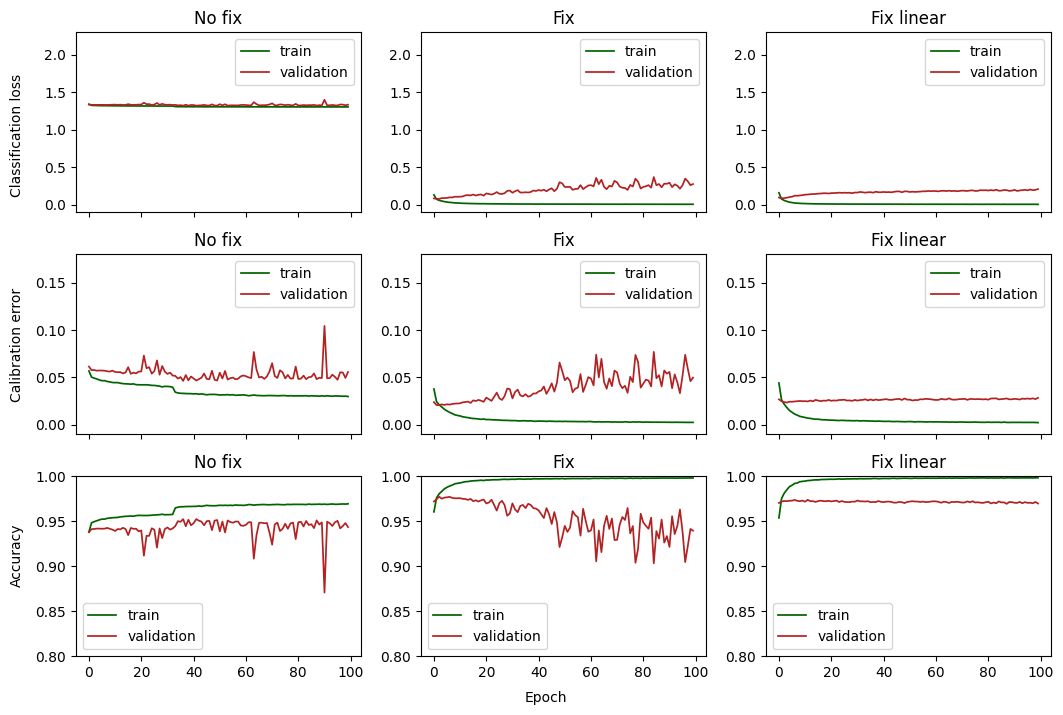

In [31]:
plot_classification_metrics(model_no_fix, model_fix, model_fix_linear)

In [38]:
import numpy as np
def plot_confusion_matrices(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    subset: str | None = None,
    prediction_key: str = "_prediction",
    labels_key: str = "celltype_fine",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6.375), sharey=False, sharex=False)

    def plot_confusion_matrix(ax, model, title, subset):
        adata = model.adata
        adata.obs[prediction_key] = model.predict()

        if subset == "validation":
            adata = adata[model.validation_indices].copy()
        elif subset == "train":
            adata = adata[model.train_indices].copy()

        df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
        conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

        _ = ax.pcolor(conf_mat, cmap="cividis", vmin=0, vmax=1)
        _ = ax.set_xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
        _ = ax.set_yticks(np.arange(0.5, len(df.index), 1), df.index)
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for model, model_name, ax in zip(models, model_names, axes, strict=False):
        plot_confusion_matrix(ax, model, model_name, subset)

    fig.text(0.0, 0.5, "Observed", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "Predicted", ha="center")
    fig.tight_layout()

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/tmp/ipykernel_2401220/1801177310.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/tmp/ipykernel_2401220/1801177310.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

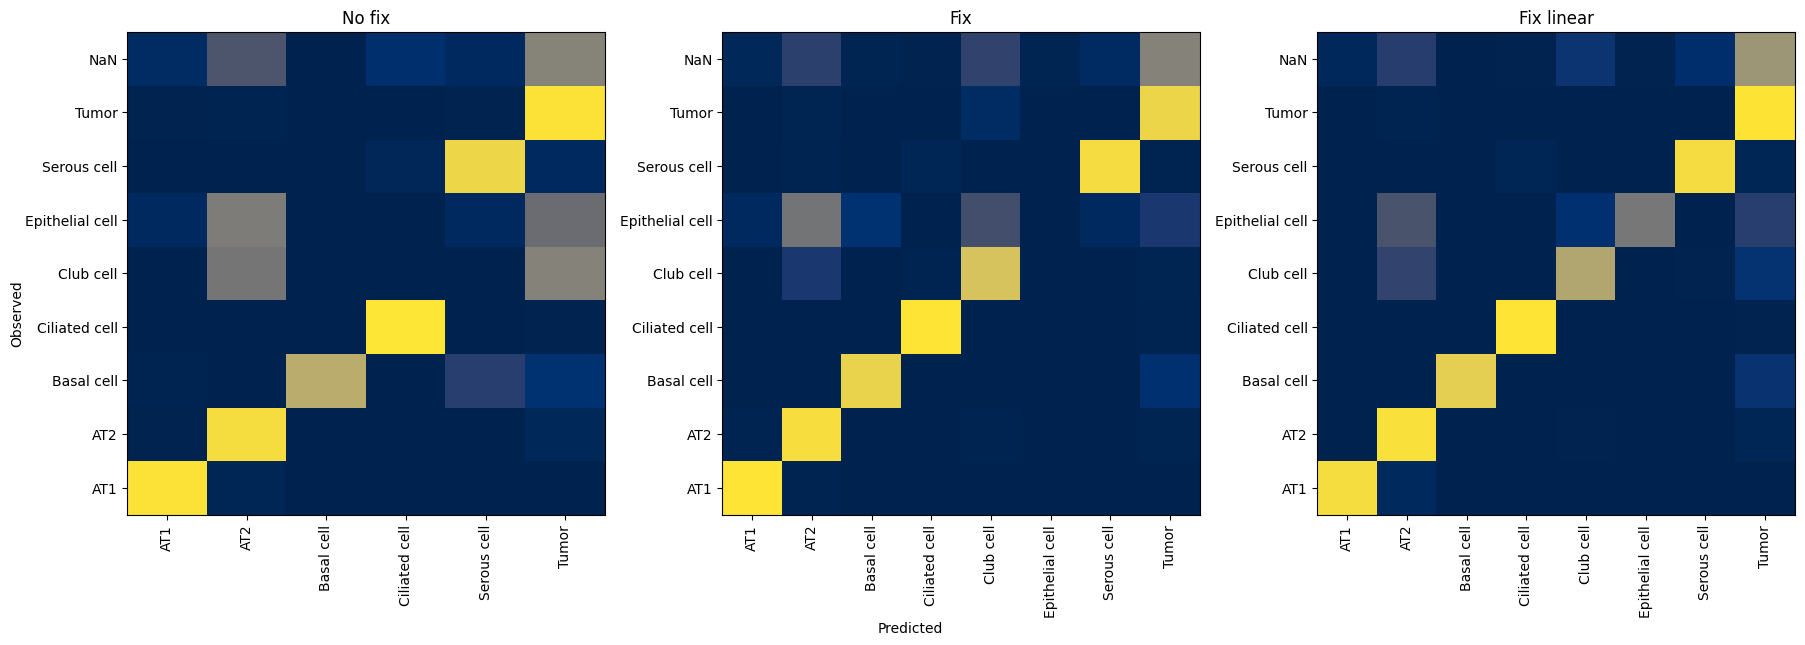

In [39]:
plot_confusion_matrices(model_no_fix, model_fix, model_fix_linear, subset="validation")

In [34]:
def plot_latent_umaps(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    color: list | str | None = None,
    subset: str | None = None,
    latent_key: str = "_latent",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), sharey=False, sharex=False)

    def plot_latent_umap(ax, model, title, subset, legend_loc):
        adata = model.adata
        adata.obsm[latent_key] = model.get_latent_representation()
        sc.pp.neighbors(adata, use_rep=latent_key)

        if subset == "validation":
            adata = model.adata[model.validation_indices].copy()
        elif subset == "train":
            adata = model.adata[model.train_indices].copy()

        sc.tl.umap(adata, min_dist=0.3)
        sc.pl.umap(
            adata,
            color=color,
            frameon=False,
            ncols=1,
            ax=ax,
            show=False,
            legend_loc=legend_loc,
        )
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]
    legend_loc = ["none", "none", "right margin"]

    for model, model_name, ax, leg_loc in zip(models, model_names, axes, legend_loc, strict=False):
        plot_latent_umap(ax, model, model_name, subset, leg_loc)

    fig.text(0.0, 0.5, "UMAP_2", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "UMAP_1", ha="center")
    fig.tight_layout()

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


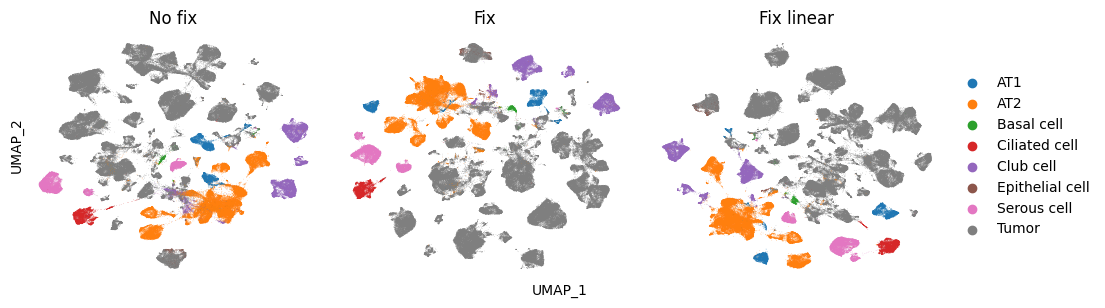

In [35]:
plot_latent_umaps(model_no_fix, model_fix, model_fix_linear, color="_prediction")

In [ ]:
plot_latent_umaps(model_no_fix, model_fix, model_fix_linear, color="Dataset")

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [36]:
X_SCVI_KEY = "X_scvi"
X_SCANVI_NO_FIX_KEY = "X_scanvi_no_fix"
X_SCANVI_FIX_KEY = "X_scanvi_fix"
X_SCANVI_FIX_LINEAR_KEY = "X_scanvi_fix_linear"

adata.obsm[X_SCVI_KEY] = model.get_latent_representation()
adata.obsm[X_SCANVI_NO_FIX_KEY] = model_no_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_KEY] = model_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_LINEAR_KEY] = model_fix_linear.get_latent_representation()

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [37]:
adata.write_h5ad('/home/data/sdzl14/NSCLC/zong/epi.scanvi.h5ad')